In [73]:
import pandas as pd

# Read X,Y traces into pandas DataFrames named X,Y
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')

In [74]:
# Producing training set and test set


# Here is how you can create a single frame with selected columns

X_features = ['runq-sz', '%%memused','proc/s','cswch/s','all_%%usr','ldavg-1','totsck','pgfree/s','plist-sz','file-nr','idel/s','tps']
XY = pd.concat([X[X_features], Y['DispFrames']], axis=1)


# Split XY into training set and test set of equal size

from sklearn.model_selection import train_test_split
train, test = train_test_split(XY, test_size = 0.3)

# Sort the train and test sets after index (which became unsorted through sampling)
train = train.sort_index(axis=0)
test = test.sort_index(axis=0)

# Extract X,Y components from test and train sets
#X_train = train[X_features]; X_test = test[X_features]
Y_train = train['DispFrames']; Y_test = test['DispFrames']

In [75]:
import numpy as np
import itertools
from sklearn import linear_model
from tqdm import tnrange, tqdm_notebook
X_train = train.drop(columns = 'DispFrames', axis = 1)

def fit_linear_reg(X,Y,X_test,Y_test):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    #RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    NMAE=np.mean(np.abs(model_k.predict(X_test) - Y_test))/np.mean(Y_test)
    #R_squared = model_k.score(X,Y)
    return NMAE

In [82]:
# Computing and evaluating a linear model
k = 12
NMAE_list,feature_list = [],[]
numb_features = []
for k in tnrange(1,len(X_train.columns)+1, desc = 'Loop...'):

    #Looping over all possible combinations: from 12 choose k
    for combo in itertools.combinations(X_train.columns,k):
        tmp_result = fit_linear_reg(X_train[list(combo)],Y_train,test[list(combo)],Y_test)   #Store temp result 
        NMAE_list.append(tmp_result)                  #Append lists
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'NMAE': NMAE_list,'features':feature_list})


<ipython-input-82-7522a86a4cce>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X_train.columns)+1, desc = 'Loop...'):


In [83]:
#df_min = df[df.groupby('numb_features')['NMAE'].transform(min) == df['NMAE']]
df.sort_values("NMAE",inplace=True)
display(df)
df.to_csv('training_all_feature_combination.csv')

,numb_features,NMAE,features
3826,9,0.088407,"(runq-sz, %%memused, proc/s, cswch/s, all_%%us..."
3326,8,0.088434,"(runq-sz, %%memused, proc/s, cswch/s, all_%%us..."
3457,8,0.088453,"(runq-sz, %%memused, cswch/s, all_%%usr, pgfre..."
2660,7,0.088478,"(runq-sz, %%memused, cswch/s, all_%%usr, pgfre..."
4036,10,0.088582,"(runq-sz, %%memused, proc/s, cswch/s, all_%%us..."
...,...,...,...
10,1,0.229109,"(idel/s,)"
70,2,0.229111,"(pgfree/s, idel/s)"
71,2,0.230434,"(pgfree/s, tps)"
11,1,0.230436,"(tps,)"


In [78]:
print(df.loc[3826]['features'])

('runq-sz', '%%memused', 'proc/s', 'cswch/s', 'all_%%usr', 'pgfree/s', 'plist-sz', 'file-nr', 'idel/s')


In [108]:
df[df.numb_features==5]

,numb_features,NMAE,features
831,5,0.089358,"(runq-sz, %%memused, cswch/s, all_%%usr, pgfre..."
1012,5,0.089386,"(runq-sz, cswch/s, all_%%usr, plist-sz, file-nr)"
1005,5,0.089553,"(runq-sz, cswch/s, all_%%usr, totsck, file-nr)"
1008,5,0.089663,"(runq-sz, cswch/s, all_%%usr, pgfree/s, plist-sz)"
1015,5,0.089694,"(runq-sz, cswch/s, all_%%usr, file-nr, idel/s)"
...,...,...,...
1293,5,0.153684,"(%%memused, all_%%usr, pgfree/s, idel/s, tps)"
1165,5,0.153803,"(%%memused, proc/s, all_%%usr, pgfree/s, tps)"
1171,5,0.155062,"(%%memused, proc/s, all_%%usr, idel/s, tps)"
1419,5,0.157936,"(proc/s, all_%%usr, pgfree/s, idel/s, tps)"


In [ ]:
runq-sz, cswch/s, all_%%usr


In [84]:
NMAE_box=[]
for i in range(1, 13):
   NMAE_box.append(df[df.numb_features==i]['NMAE'])


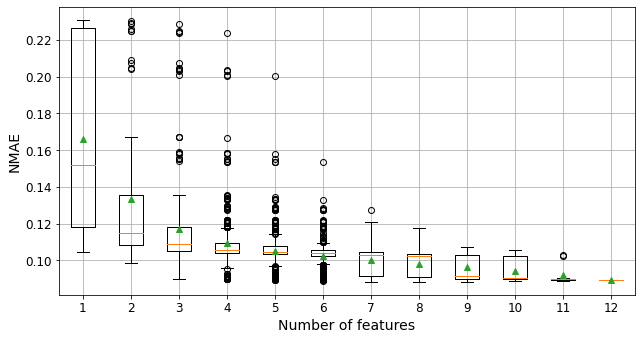

In [85]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
# Creating plot 
bp = ax.boxplot(NMAE_box,showmeans=True) 
font_size=14  
plt.xlabel('Number of features', fontsize=font_size)
plt.ylabel('NMAE', fontsize=font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size-2)
plt.tick_params(axis='both', which='minor', labelsize=font_size-4)
#plt.tight_layout()
plt.grid()
plt.savefig(r"\kth course\network analytics\project\pic\3.2.png",dpi=300,bbox_inches='tight')
plt.show()

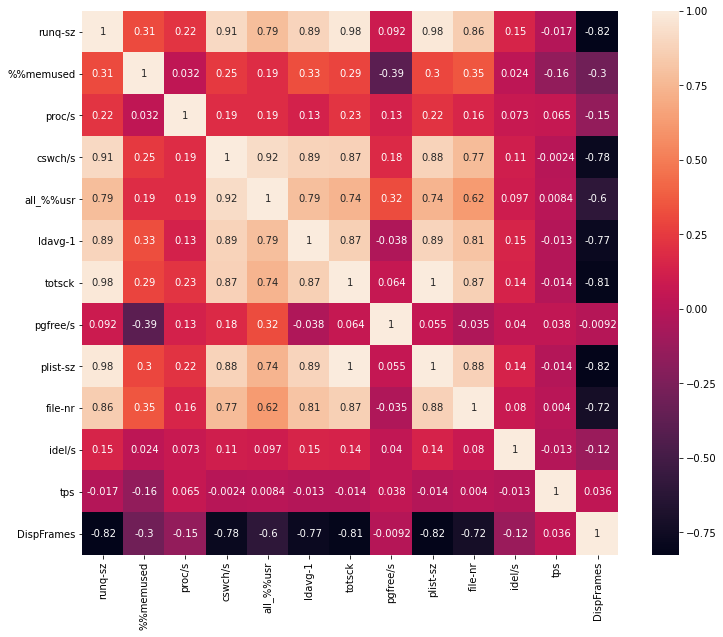

In [86]:
import seaborn as sns
corr=train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr,annot=True)
plt.savefig(r"\kth course\network analytics\project\pic\3.4.png",dpi=300,bbox_inches='tight')
plt.show()

In [87]:
corr['c'] = corr.DispFrames**2
corr_ = corr.sort_values('c')
corr_.DispFrames

pgfree/s     -0.009175
tps           0.036451
idel/s       -0.121000
proc/s       -0.152851
%%memused    -0.303143
all_%%usr    -0.599089
file-nr      -0.721316
ldavg-1      -0.768124
cswch/s      -0.778812
totsck       -0.810072
plist-sz     -0.815498
runq-sz      -0.824706
DispFrames    1.000000
Name: DispFrames, dtype: float64

In [88]:
feature_list=['runq-sz','plist-sz','totsck','cswch/s','ldavg-1','file-nr','all_%%usr','%%memused','proc/s','idel/s','tps','pgfree/s',]

In [89]:
NMAE_cor=[]
for i in range(1, 13):
    tmp_result = fit_linear_reg(X_train[feature_list[0:i]],Y_train,test[feature_list[0:i]],Y_test)
    NMAE_cor.append(tmp_result)

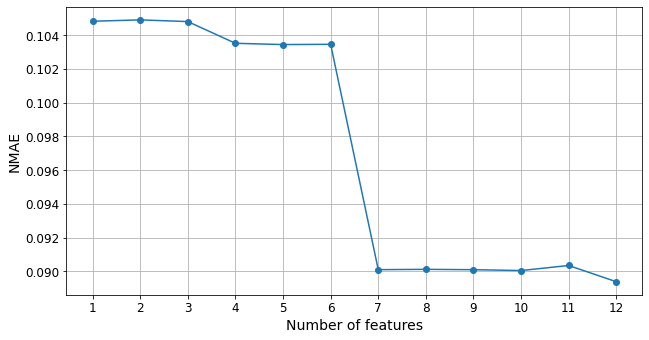

In [90]:
from matplotlib.pyplot import MultipleLocator
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax = fig.add_axes([0, 0, 1, 1]) 
my_xticks=list(range(1, 13))
plt.plot(my_xticks,NMAE_cor,marker='o')
plt.xlabel('Number of features', fontsize=font_size)
plt.ylabel('NMAE', fontsize=font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size-2)
plt.tick_params(axis='both', which='minor', labelsize=font_size-4)

x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid()
plt.savefig(r"\kth course\network analytics\project\pic\3.3.png",dpi=300,bbox_inches='tight')

In [91]:
list(range(1, 13))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [92]:
NMAE_min=[]
for i in range(1, 13):
     NMAE_min.append(df[df.numb_features==i]['NMAE'].min())

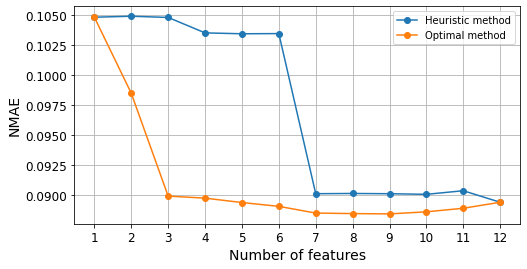

In [93]:
from matplotlib.pyplot import MultipleLocator
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
my_xticks=list(range(1, 13))
plt.plot(my_xticks, NMAE_cor,marker='o',label='Heuristic method')
plt.plot(my_xticks, NMAE_min,marker='o',label='Optimal method')
font_size=14  
plt.xlabel('Number of features', fontsize=font_size)
plt.ylabel('NMAE', fontsize=font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size-2)
plt.tick_params(axis='both', which='minor', labelsize=font_size-4)
plt.legend()
x_major_locator=MultipleLocator(1)
ax=plt.gca()
plt.grid()
ax.xaxis.set_major_locator(x_major_locator)
plt.savefig(r"\kth course\network analytics\project\pic\3.5.png",dpi=300,bbox_inches='tight')
plt.show()